<a href="https://colab.research.google.com/github/RishabhQuantum/Nuclear-Dynamics/blob/Nuclear-Spin-Polarization/Nuclear_purity_2Spin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 60.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import physical_constants
from qutip import (Qobj,qeye,sigmax,sigmay,sigmaz,singlet_state,triplet_states,tensor,mesolve,negativity,partial_transpose,entropy)

In [3]:
sx = 0.5*sigmax()
sy = 0.5*sigmay()
sz = 0.5*sigmaz()

In [4]:
# spin relaxation
kra = 1e6
krb = 1e6

c_ops = [
    np.sqrt(kra) * tensor(sx,qeye(2),qeye(2),qeye(2)),
    np.sqrt(kra) * tensor(sy,qeye(2),qeye(2),qeye(2)),
    np.sqrt(kra) * tensor(sz,qeye(2),qeye(2),qeye(2)),
    np.sqrt(krb) * tensor(qeye(2),sx,qeye(2),qeye(2)),
    np.sqrt(krb) * tensor(qeye(2),sy,qeye(2),qeye(2)),
    np.sqrt(krb) * tensor(qeye(2),sz,qeye(2),qeye(2)),
]

In [5]:
# physical constants
hbar = physical_constants['Planck constant over 2 pi'][0]
g_e = physical_constants['electron g factor'][0]
mu_B = physical_constants['Bohr magneton'][0]
g_n = physical_constants['proton g factor'][0] # proton g-factor
mu_n = physical_constants['nuclear magneton'][0]
gammae = (mu_B*g_e)/(hbar*1000) # 1/(mT*s)
gamman = (mu_n*g_n)/(hbar*1000) # 1/(mT*s) # gyromagnetic ration for proton

In [6]:
#interaction strengths
B = 1*gammae # mT - geomagnetic field
Bn = B*gamman/gammae
a1 = 10*gammae # mT
a2 = 1*gammae # mT
J = -0.0035*gammae # -0.0035 mT - exchange and dipole values taken to be similar to cry4 case: https://doi.org/10.1038/s41586-021-03618-9
D = 1.85*gammae/(2**3) # 2 nm

In [11]:
# initial state - singlet state for elctrons, completely mixed for nucleus
# electronA ⊗ electronB ⊗ NucleusA
# nuclear spins is spin-1/2 (Hydrogen - 1)
#PT = tensor(triplet_states()[0]*triplet_states()[0].dag() + triplet_states()[1]*triplet_states()[1].dag() + triplet_states()[2]*triplet_states()[2].dag(),qeye(2))
PS=tensor(singlet_state()*singlet_state().dag(),qeye(2),qeye(2))
PT = tensor(qeye(2),qeye(2),qeye(2),qeye(2)) - PS
rhoi= (PS)/2 # Singlet initial state
#rhoi= (PT)/6 # Triplet initial state
#rhoi= (PS+PT)/8 # Identity initial state

In [12]:
# Hamiltonian
DipoleZ = D*(tensor(sx,sx,qeye(2),qeye(2))+tensor(sy,sy,qeye(2),qeye(2))-2*tensor(sz,sz,qeye(2),qeye(2)))
Exchange = J*(tensor(sx,sx,qeye(2),qeye(2))+tensor(sy,sy,qeye(2),qeye(2))+tensor(sz,sz,qeye(2),qeye(2)))
Zeeman_A = -B*tensor(sz,qeye(2),qeye(2),qeye(2))
Zeeman_B = -B*tensor(qeye(2),sz,qeye(2),qeye(2))
Zeeman_n_1 = Bn*tensor(qeye(2),qeye(2),sz,qeye(2))
Zeeman_n_2 = Bn*tensor(qeye(2),qeye(2),qeye(2),sz)
HFI_1 = a1*(tensor(sx,qeye(2),sx,qeye(2))+tensor(sy,qeye(2),sy,qeye(2))+tensor(sz,qeye(2),sz,qeye(2)))
HFI_2 = a2*(tensor(sx,qeye(2),qeye(2),sx)+tensor(sy,qeye(2),qeye(2),sy)+tensor(sz,qeye(2),qeye(2),sz))
Ham = DipoleZ + Exchange +Zeeman_A + Zeeman_B + HFI_1 + Zeeman_n_1 + Zeeman_n_2 + HFI_2

In [13]:
# time evolution
tlist = np.linspace(0, 2.0e-6,2000)
rhot = mesolve(Ham, rhoi, tlist,c_ops=c_ops)
# partial density matrices
rhot_e = [rho.ptrace([0, 1]) for rho in rhot.states]
rhot_n = [rho.ptrace([2]) for rho in rhot.states]
# purity
purity_e = [(rho**2).tr() for rho in rhot_e]
purity_n = [(rho**2).tr() for rho in rhot_n]

In [14]:
# projecting the electronic subsystem to singlet subspace
# total density matix post measurement
rhot_pm = [((PS).dag()*rho*(PS)/((PS*rho).tr())) for rho in rhot.states] # Singlet Projection
#rhot_pm = [((PT).dag()*rho*(PT)/((PT*rho).tr())) for rho in rhot.states[1:2000]] # Triplet Projection
#rhot_pm = [((PS+PT).dag()*rho*(PS+PT)/(((PS+PT)*rho).tr())) for rho in rhot.states[1:2000]] # Identity Projection
# partial density matrices
rhot_pm_e = [rho.ptrace([0, 1]) for rho in rhot_pm]
rhot_pm_n1 = [rho.ptrace([2]) for rho in rhot_pm]
rhot_pm_n2 = [rho.ptrace([3]) for rho in rhot_pm]
# purity
purity_pm_e = [(rho**2).tr() for rho in rhot_pm_e]
purity_pm_n1 = [(rho**2).tr() for rho in rhot_pm_n1]
purity_pm_n2 = [(rho**2).tr() for rho in rhot_pm_n2]
# polarization
pol_pm_n1 = [np.abs(rho[0,0]-rho[1,1]) for rho in rhot_pm_n1]
pol_pm_n2 = [np.abs(rho[0,0]-rho[1,1]) for rho in rhot_pm_n2]

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


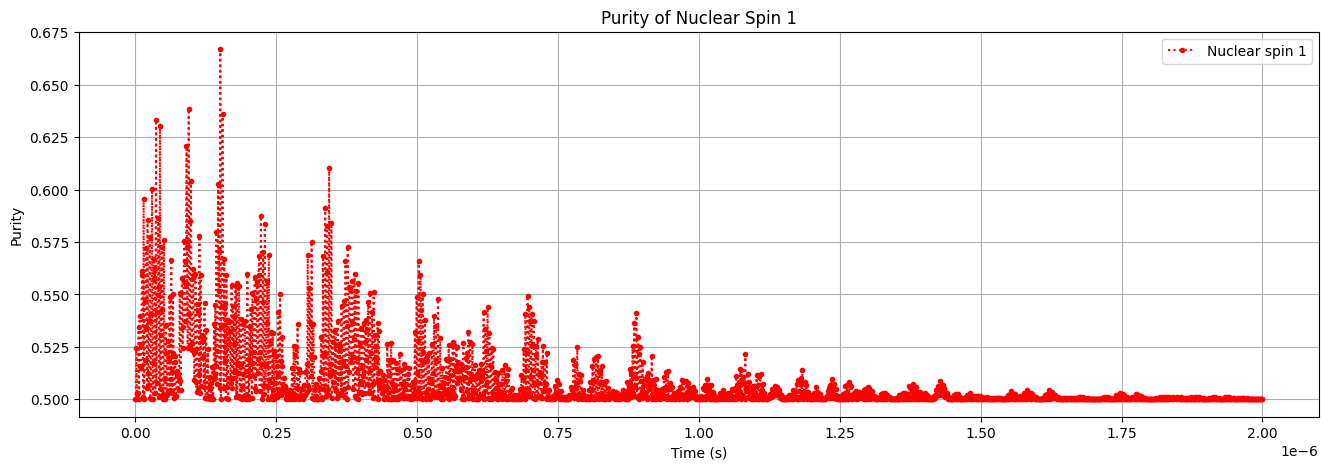

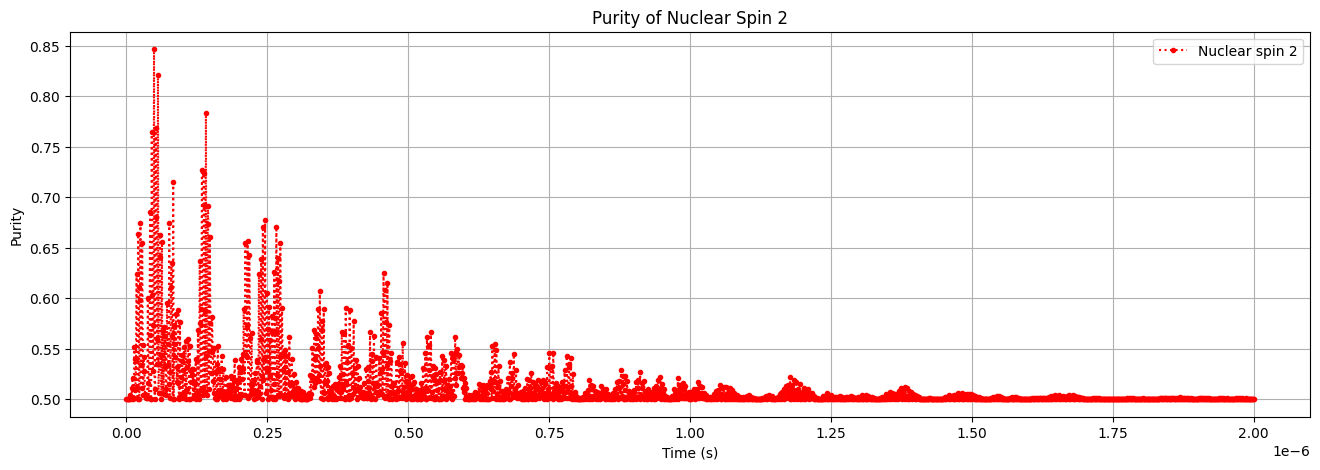

In [15]:
# post projection plots

# nuclear purity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, purity_pm_n1, label='Nuclear spin 1',linestyle=':', marker = '.',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Purity')
plt.title('Purity of Nuclear Spin 1')
plt.grid(True)
plt.legend()
plt.ticklabel_format(useOffset=False)
plt.show()

# nuclear purity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, purity_pm_n2, label='Nuclear spin 2',linestyle=':', marker = '.',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Purity')
plt.title('Purity of Nuclear Spin 2')
plt.grid(True)
plt.legend()
plt.ticklabel_format(useOffset=False)
plt.show()